In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib  import colors
import seaborn as sns
import geopandas as gpd

import random

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import time

import xgboost as xgb 
from xgboost import plot_importance

from sklearn.preprocessing import  StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, learning_curve, validation_curve,cross_validate, KFold, cross_val_predict,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn import feature_selection

from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor


import os
os.environ['KERAS_BACKEND']='tensorflow'

from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose


# from IPython.display import HTML
# style = "<style>svg{width:50% !important;   height:50% !important;} </style>"
# HTML(style)

%matplotlib inline

np.random.seed(1000)

Using TensorFlow backend.


In [2]:
!cat ~/.keras/keras.json

{
    "floatx": "float32",
    "epsilon": 1e-07,
    "backend": "tensorflow",
    "image_data_format": "channels_last"
}

In [3]:
def pre_data(X,y, perc):
    '''
    INPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    
    OUTPUT
    X'
    
    This function cleans df using the following steps to produce X':
    1. For each numeric variable in X, fill the column with the mean value of the column.
    2. Create dummy columns for all the categorical variables in X, drop the original columns
    '''

    # split data into train and test
    X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=perc, random_state=101)
    
    # scale X_train
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
    # get feature list
    col_list=X.columns
    
    return X_train, y_train, X_test, y_test, col_list

def plot_regression_results(y_true, y_pred, title, show, scores):
    
    """Scatter plot of the predicted vs true targets."""
    _, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    if show:
        extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                              edgecolor='none', linewidth=0)
        ax.legend([extra], [scores], loc='upper left')
    ax.set_title(title)
    plt.savefig(title)
    
def score_cv(model, X,y, title, cv=5):
    
    start_time=time.time()
    kf = KFold(cv, shuffle=True, random_state=42).get_n_splits(X)

    score = cross_validate(model, X, y,scoring=['r2','neg_mean_absolute_error','neg_mean_squared_error'],
                           n_jobs=-1, verbose=0, cv=kf)

    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(model, X, y, n_jobs=-1, verbose=0)

    plot_regression_results(y, y_pred, title, True,
                            (r'$R^2={:.2f} \pm {:.2f}$' + '\n' + r'$MAE={:.2f} \pm {:.2f}$' + '\n'  + r'$MSE={:.2f} \pm {:.2f}$')
                            .format( np.mean(score['test_r2']),
                                    np.std(score['test_r2']),
                                    -np.mean(score['test_neg_mean_absolute_error']),
                                    np.std(score['test_neg_mean_absolute_error']),
                                    -np.mean(score['test_neg_mean_squared_error']),
                                    np.std(score['test_neg_mean_squared_error'])))

    
def plot_validation_curve(clf,X,Y,param,paramlist,K,x_label,ptitle):

    train_score, valid_score = validation_curve(clf, X, Y, param_name=param, param_range=paramlist, cv=K, scoring='neg_mean_squared_error')

    train_score_mean = train_score.mean(1)
    train_score_std = train_score.std(1)
    valid_score_mean = valid_score.mean(1)
    valid_score_std = valid_score.std(1)

    plt.grid()
    plt.fill_between(paramlist, train_score_mean - train_score_std,
                     train_score_mean + train_score_std, color='r', alpha=0.1)
    plt.fill_between(paramlist, valid_score_mean - valid_score_std,
                     valid_score_mean + valid_score_std, color='g', alpha=0.1)

    plt.plot(paramlist, train_score_mean, 'o-', c='r', label='train score')
    plt.plot(paramlist, valid_score_mean, 'o-', c='g', label='validation score')
    plt.legend(loc='best')
    plt.title(ptitle)
    plt.xlabel(x_label)
    plt.ylabel('neg_mean_squared_error')
    plt.savefig(ptitle)
    plt.show()


def learning_curve_plot(estimator, X, y, cv, title, ylims=None):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring='neg_mean_squared_error', train_sizes= np.linspace(.1, 1.0, 5))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title('Learning Curve')
    # axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                      train_scores_mean + train_scores_std, alpha=0.1,color="r")
    
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                      test_scores_mean + test_scores_std, alpha=0.1,color="g")
    
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    
    axes.set_ylim(ylims)
    
    axes.legend(loc="best")
    plt.savefig(title)

    
def model_evaluation(model, X_train, X_test, y_train, y_test, title):
    
    st=time.time()
    model=model.fit(X_train,y_train)
    et=time.time()
    y_test_predict=model.predict(X_test)
    y_train_predict=model.predict(X_train)
    
    train_MAE=round(mean_absolute_error(y_train, y_train_predict),4)
    test_MAE=round(mean_absolute_error(y_test, y_test_predict),4)
    train_MSE=round(mean_squared_error(y_train, y_train_predict),4)
    test_MSE=round(mean_squared_error(y_test, y_test_predict),4)
    train_r2=round(r2_score(y_train, y_train_predict),4)
    test_r2=round(r2_score(y_test, y_test_predict),4)
    
#     train_MAE=round(mean_absolute_error(np.exp(y_train)-1, np.exp(y_train_predict)-1),4)
#     test_MAE=round(mean_absolute_error(np.exp(y_test)-1, np.exp(y_test_predict)-1),4)
#     train_MSE=round(mean_squared_error(np.exp(y_train)-1, np.exp(y_train_predict)-1),4)
#     test_MSE=round(mean_squared_error(np.exp(y_test)-1, np.exp(y_test_predict)-1),4)
#     train_r2=round(r2_score(y_train, y_train_predict),4)
#     test_r2=round(r2_score(y_test, y_test_predict),4)
    
    
    print("Training time =", round(et-st,4), 'seconds')
    print("\nTraining MAE =", train_MAE)
    print("Validation MAE =", test_MAE)
    print("\nTraining MSE =", train_MSE)
    print("Validation MSE =", test_MSE)
    print("\nTraining r2 =", train_r2)
    print("Validation r2 =", test_r2)

    plot_regression_results(y_test, y_test_predict, title, False, '0')
    
    
def nn_evaluation(model,  X_train, X_test, y_train, y_test, skip_epochs=0):
    
    y_test_predict=model.predict(X_test)
    y_train_predict=model.predict(X_train)
    
    print("\nTraining MAE =", round(mean_absolute_error(y_train, y_train_predict),4))
    print("Validation MAE =", round(mean_absolute_error(y_test, y_test_predict),4))
    print("\nTraining MSE =", round(mean_squared_error(y_train, y_train_predict),4))
    print("Validation MSE =", round(mean_squared_error(y_test, y_test_predict),4))
    print("\nTraining r2 =", round(r2_score(y_train, y_train_predict),4))
    print("Validation r2 =", round(r2_score(y_test, y_test_predict),4))
    
    
    #-------------------------------------------------
    
    result=model.history.history
    plt.plot(list(range((skip_epochs+1), len(result['loss'])+1)), result['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1), len(result['val_loss'])+1)), result['val_loss'][skip_epochs:], label='Train', color='Blue')
    plt.legend()
    plt.title('Training and test loss at each epoch')
    plt.show()
    
    #-------------------------------------------------
    
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
    fig.suptitle('Prediction / Actual Values')
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test,y_test_predict, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_predict, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()
    
    
def ft_importance(fi_list, col):
    fi=pd.DataFrame(fi_list, columns=['weight'], index=col)
    fi.sort_values('weight', inplace=True, ascending=False)
    fi['cum_sum']=fi['weight'].cumsum()
    
    plt.figure(figsize=(8,20))
    plt.barh(fi.index, fi.weight)
    plt.title('Feature Importance from Randome Forest Model -a First Try')
    plt.xlabel('Feature Importance')
    plt.margins(y=0.01)
    plt.show()
    
    return fi

In [4]:
df=pd.read_csv('Listing_full_cleaned_dummied.csv')
print(df.shape)

pd.set_option('display.max_columns', len(df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)

(8448, 93)


In [5]:
X=df.drop('price', axis=1)
y=df['price']
X_train, y_train, X_test, y_test, col_list=pre_data(X,y, 0.20)
X.head()

,host_is_superhost,host_total_listings_count,host_identity_verified,bathrooms,accommodates,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights_avg_ntm,availability_90,number_of_reviews,instant_bookable,host_days_active,easy_check_in,breakfast,TV,pets,elevator,free_parking,gym,family_kid_friendly,yard,carbon_monoxide_detect,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_90-99%,host_response_rate_99-100%,host_response_rate_<80%,host_response_rate_unknown,neighbourhood_cleansed_Bernal Heights,neighbourhood_cleansed_Castro/Upper Market,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Crocker Amazon,neighbourhood_cleansed_Diamond Heights,neighbourhood_cleansed_Downtown/Civic Center,neighbourhood_cleansed_Excelsior,neighbourhood_cleansed_Financial District,neighbourhood_cleansed_Glen Park,neighbourhood_cleansed_Golden Gate Park,neighbourhood_cleansed_Haight Ashbury,neighbourhood_cleansed_Inner Richmond,neighbourhood_cleansed_Inner Sunset,neighbourhood_cleansed_Lakeshore,neighbourhood_cleansed_Marina,neighbourhood_cleansed_Mission,neighbourhood_cleansed_Nob Hill,neighbourhood_cleansed_Noe Valley,neighbourhood_cleansed_North Beach,neighbourhood_cleansed_Ocean View,neighbourhood_cleansed_Outer Mission,neighbourhood_cleansed_Outer Richmond,neighbourhood_cleansed_Outer Sunset,neighbourhood_cleansed_Pacific Heights,neighbourhood_cleansed_Parkside,neighbourhood_cleansed_Potrero Hill,neighbourhood_cleansed_Presidio,neighbourhood_cleansed_Presidio Heights,neighbourhood_cleansed_Russian Hill,neighbourhood_cleansed_Seacliff,neighbourhood_cleansed_South of Market,neighbourhood_cleansed_Treasure Island/YBI,neighbourhood_cleansed_Twin Peaks,neighbourhood_cleansed_Visitacion Valley,neighbourhood_cleansed_West of Twin Peaks,neighbourhood_cleansed_Western Addition,property_type_Condominium,property_type_Hotel,property_type_House,property_type_Other,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_cleanliness_10,review_scores_cleanliness_9,review_scores_checkin_9,review_scores_location_10,review_scores_location_9,review_scores_value_10,review_scores_value_9,review_scores_value_unknown,cancellation_policy_moderate,cancellation_policy_strict,time_since_first_review_0.5-2 years,time_since_first_review_2-3 years,time_since_first_review_3-4 years,time_since_first_review_4+ years,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months
0,1.0,1.0,1,1.0,3,100.0,100.0,25.0,1,30.0,12,226,0,4143.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0
1,1.0,2.0,1,1.0,2,0.0,10.0,20.0,1,5.0,74,175,0,4013.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0
2,0.0,2.0,1,1.0,5,0.0,100.0,0.0,30,60.0,1,111,0,3929.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0
3,1.0,10.0,1,4.0,2,200.0,50.0,12.0,32,60.0,90,18,0,3822.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0
4,1.0,10.0,1,4.0,2,200.0,50.0,12.0,32,90.0,90,8,0,3822.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0


## - PCA

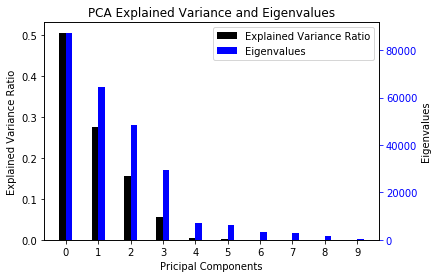

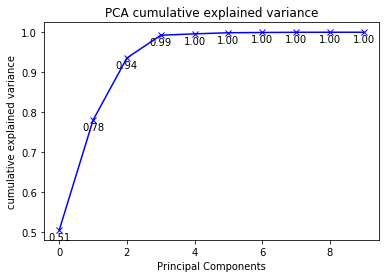

,host_is_superhost,host_total_listings_count,host_identity_verified,bathrooms,accommodates,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights_avg_ntm,availability_90,number_of_reviews,instant_bookable,host_days_active,easy_check_in,breakfast,TV,pets,elevator,free_parking,gym,family_kid_friendly,yard,carbon_monoxide_detect,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_response_rate_90-99%,host_response_rate_99-100%,host_response_rate_<80%,host_response_rate_unknown,neighbourhood_cleansed_Bernal Heights,neighbourhood_cleansed_Castro/Upper Market,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Crocker Amazon,neighbourhood_cleansed_Diamond Heights,neighbourhood_cleansed_Downtown/Civic Center,neighbourhood_cleansed_Excelsior,neighbourhood_cleansed_Financial District,neighbourhood_cleansed_Glen Park,neighbourhood_cleansed_Golden Gate Park,neighbourhood_cleansed_Haight Ashbury,neighbourhood_cleansed_Inner Richmond,neighbourhood_cleansed_Inner Sunset,neighbourhood_cleansed_Lakeshore,neighbourhood_cleansed_Marina,neighbourhood_cleansed_Mission,neighbourhood_cleansed_Nob Hill,neighbourhood_cleansed_Noe Valley,neighbourhood_cleansed_North Beach,neighbourhood_cleansed_Ocean View,neighbourhood_cleansed_Outer Mission,neighbourhood_cleansed_Outer Richmond,neighbourhood_cleansed_Outer Sunset,neighbourhood_cleansed_Pacific Heights,neighbourhood_cleansed_Parkside,neighbourhood_cleansed_Potrero Hill,neighbourhood_cleansed_Presidio,neighbourhood_cleansed_Presidio Heights,neighbourhood_cleansed_Russian Hill,neighbourhood_cleansed_Seacliff,neighbourhood_cleansed_South of Market,neighbourhood_cleansed_Treasure Island/YBI,neighbourhood_cleansed_Twin Peaks,neighbourhood_cleansed_Visitacion Valley,neighbourhood_cleansed_West of Twin Peaks,neighbourhood_cleansed_Western Addition,property_type_Condominium,property_type_Hotel,property_type_House,property_type_Other,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_cleanliness_10,review_scores_cleanliness_9,review_scores_checkin_9,review_scores_location_10,review_scores_location_9,review_scores_value_10,review_scores_value_9,review_scores_value_unknown,cancellation_policy_moderate,cancellation_policy_strict,time_since_first_review_0.5-2 years,time_since_first_review_2-3 years,time_since_first_review_3-4 years,time_since_first_review_4+ years,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_2-8 weeks,time_since_last_review_6-12 months
pc-0,-0.180711,0.194005,-0.130736,0.019314,-0.059476,-0.000980,0.052323,-0.110072,0.193142,0.147376,0.073751,-0.210624,0.090909,-0.170133,-0.139187,-0.063151,0.044734,0.050723,0.219110,-0.202048,0.170641,-0.137048,-0.095677,-0.054018,0.014746,0.103817,-0.112662,0.226441,-0.222791,0.047411,0.024571,-0.068235,-0.035175,0.038621,-0.012232,-0.017362,0.120145,-0.029553,0.075242,-0.024143,-0.003482,-0.021235,-0.022207,-0.034868,-0.013031,-0.001448,-0.027578,0.049341,-0.049469,0.018670,-0.009431,-0.035204,-0.025959,-0.055279,-0.007590,-0.031191,-0.031782,-0.007777,0.002509,0.020689,-0.015868,0.133047,0.008863,-0.018808,-0.021531,-0.033971,0.006950,-0.005193,0.095717,-0.140410,0.014685,0.064158,-0.067422,0.050155,-0.249443,-0.034424,0.005773,-0.228033,-0.065381,-0.189400,-0.107458,0.306964,-0.155969,0.043577,-0.057556,-0.070458,-0.073909,-0.142514,0.000787,-0.039478,-0.121496,-0.000755
pc-1,0.055006,0.214334,0.210858,0.000349,0.214040,0.205668,0.367429,0.054213,0.162400,0.113473,-0.069227,-0.058813,-0.212237,0.183263,0.054423,-0.055558,0.146819,0.129143,-0.060121,0.048795,-0.024696,0.124249,0.111411,0.094870,0.041170,0.232536,-0.291276,0.077389,-0.125531,-0.033713,0.114557,0.034638,0.050750,0.000541,-0.031167,0.000423,-0.148247,-0.035036,-0.033176,0.016311,0.016596,-0.018245,0.004449,0.009308,-0.031967,0.046625,0.021577,0.013015,0.039118,-0.012219,-0.039483,-0.021486,-0.009154,-0.044848,0.025970,-0.026644,0.041724,-0.004659,0

In [6]:
from sklearn.decomposition import PCA

def algo_PCA(X, n):
    
    pca=PCA(random_state=10)
    pca.set_params(n_components=n).fit(X)
    
    #------------------------------------------------------------
    """ explained_variance_ratio_"""
    # Percentage of variance explained by each of the selected components.
    fig,ax1 = plt.subplots()
    evr=ax1.bar([(i-0.1) for i in range(len(pca.explained_variance_ratio_))], pca.explained_variance_ratio_,width=0.2, color='k', align='center')
    ax1.set_xticks(np.arange(0,len(pca.explained_variance_ratio_),1)) 
    ax1.set_xlabel('Pricipal Components')
    ax1.set_ylabel('Explained Variance Ratio')
        
    """ singular_values_"""
    # corresponding to each of the selected components. equal to the 2-norms of the n_components variables in the lower-dimensional space.
    ax2=ax1.twinx()
    sv=ax2.bar([(i+0.1) for i in range(len(pca.singular_values_))], pca.singular_values_, width=0.2,color='b',align='center')
    ax2.tick_params('y', colors='b')
    ax2.set_ylabel('Eigenvalues')

    plt.title('PCA Explained Variance and Eigenvalues')
    plt.legend([evr, sv],['Explained Variance Ratio', 'Eigenvalues'])
    plt.show()
        
    #--------------------------------------------------------------------------------
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_), 'bx-')
    ax1.set_xticks(np.arange(0,len(pca.explained_variance_ratio_),1))  # Set label locations.
    for x,y in enumerate(np.cumsum(pca.explained_variance_ratio_)):
        label = "{:.2f}".format(y)
        plt.annotate(label, # this is the text
                        (x,y), # this is the point to label
                        textcoords="offset points", # how to position the text
                        xytext=(0,-10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center
    plt.xlabel('Principal Components')
    plt.ylabel('cumulative explained variance');
    plt.title('PCA cumulative explained variance')
    plt.show()
    
    return pca


pca=algo_PCA(X, 10)

X_train_PCA=pca.fit_transform(X_train)
X_test_PCA=pca.transform(X_test)

# distribution of principal components
pc=pd.DataFrame(pca.components_, columns=col_list,
                index=[ "pc-0", "pc-1", "pc-2", "pc-3", "pc-4", "pc-5", "pc-6", "pc-7", "pc-8", "pc-9"]) 
pc

In [7]:
# rename as the feature with the highest values in each p.c.
most_important = [np.abs(pca.components_[i]).argmax() for i in range(10)]
most_important_names = [col_list[most_important[i]] for i in range(10)]
dic = {'PC-{}'.format(i): most_important_names[i] for i in range(10)}
pc_feature = pd.DataFrame(sorted(dic.items()), columns=["PC", "FEATURES"])
pc_feature

,PC,FEATURES
0,PC-0,review_scores_value_unknown
1,PC-1,cleaning_fee
2,PC-2,review_scores_cleanliness_10
3,PC-3,property_type_Hotel
4,PC-4,review_scores_value_9
5,PC-5,accommodates
6,PC-6,host_response_rate_unknown
7,PC-7,time_since_first_review_0.5-2 years
8,PC-8,room_type_Shared room
9,PC-9,neighbourhood_cleansed_South of Market


# Baseline Linear Regression Models
The three baseline models are **Linear Regression**, **Lasso Regression**, and **Ridge Regression**. 

score each baseline model on both MSE, MAE and R^2 to evaluate them, and average the scores from 5-fold cross validation.

## - Linear Regression

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's **Robustscaler()** method on pipeline


Training time = 0.0822 seconds

Training MAE = 0.3033
Validation MAE = 0.3149

Training MSE = 0.1755
Validation MSE = 0.1912

Training r2 = 0.6456
Validation r2 = 0.6158


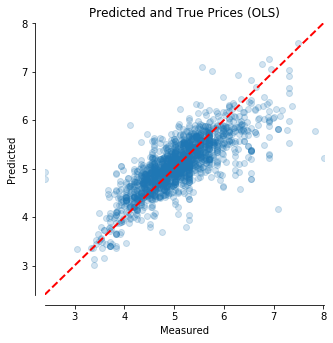

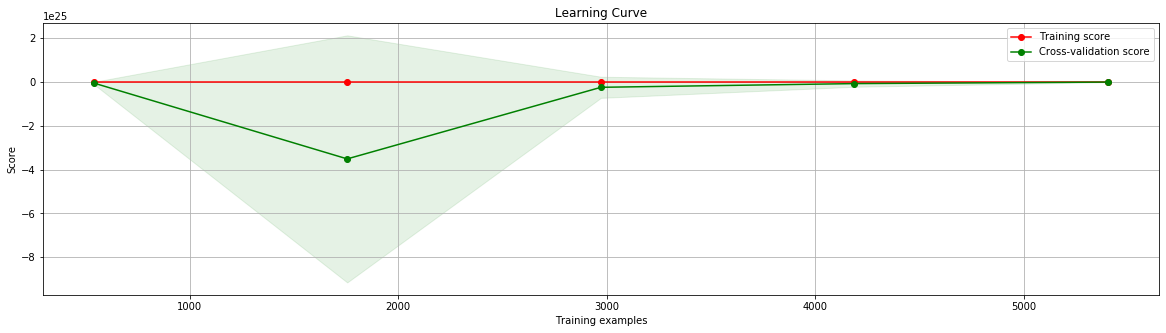

In [8]:
lr=LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=-1)

model_evaluation(lr, X_train, X_test, y_train, y_test, 'Predicted and True Prices (OLS)')

learning_curve_plot(lr, X_train, y_train, 5, 'Learning Curve (OLS)')

## - Lasso Regression

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's **Robustscaler()** method on pipeline

Training time = 0.3231 seconds

Training MAE = 0.3034
Validation MAE = 0.3144

Training MSE = 0.1758
Validation MSE = 0.1908

Training r2 = 0.645
Validation r2 = 0.6165

optimal alpha for lasso is: 0.0005


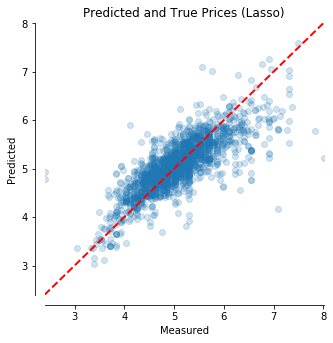

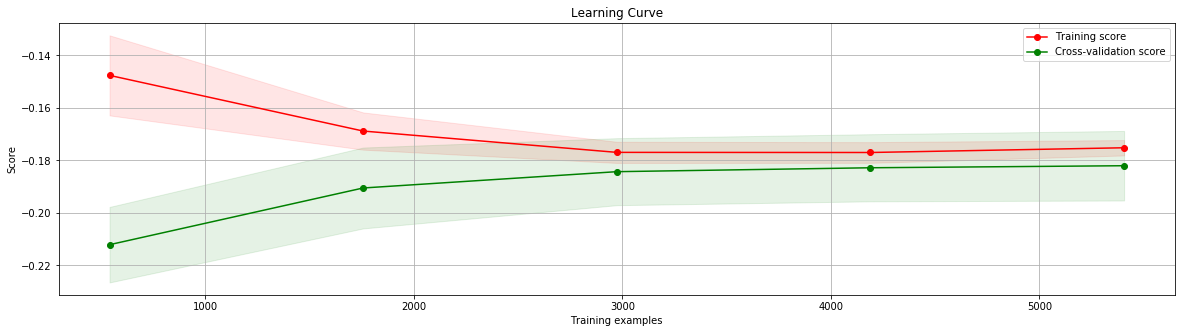

In [9]:
alpha_ls= np.array([1,0.1,0.01,0.001,0.0005,0.0001])
lasso=LassoCV(alphas=alpha_ls, fit_intercept=True, normalize=False, copy_X=True, cv = 5,  n_jobs=-1, random_state=1) 
lasso_pip=make_pipeline(RobustScaler(), lasso)

model_evaluation(lasso_pip, X_train, X_test, y_train, y_test, 'Predicted and True Prices (Lasso)')

print('\noptimal alpha for lasso is: {}'. format(lasso.alpha_))

learning_curve_plot(lasso, X_train, y_train,  5, 'Learning Curve (Lasso)')

****  Features with zero weight ****
host_response_time_within a few hours   -0.0
host_response_rate_90-99%                0.0
host_response_rate_99-100%               0.0
time_since_first_review_3-4 years       -0.0
dtype: float64


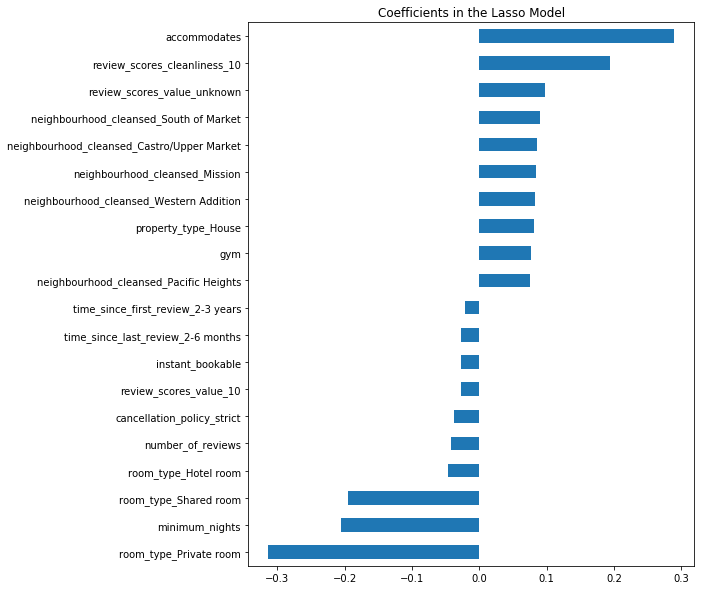

In [10]:
coef = pd.Series(lasso.coef_, index = col_list)   
print('****  Features with zero weight ****')
print(coef[coef==0])

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
plt.figure(figsize=(8.0, 10.0))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model");
plt.savefig('Coefficients in the Lasso Model.png',bbox_inches = 'tight')

## - RidgeCV

Training time = 0.4981 seconds

Training MAE = 0.3033
Validation MAE = 0.3149

Training MSE = 0.1755
Validation MSE = 0.1912

Training r2 = 0.6456
Validation r2 = 0.6158

optimal alpha for lasso is: 1.0


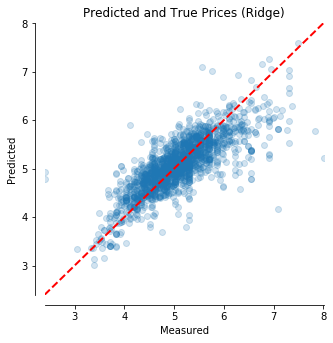

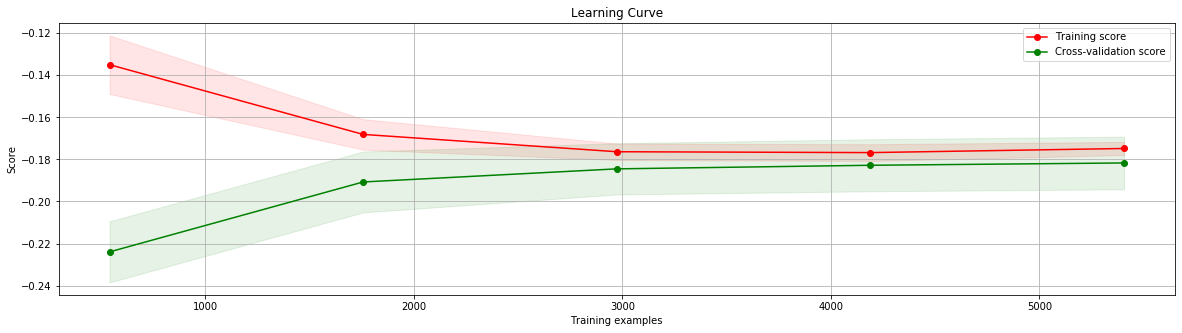

In [11]:
# Tuning paramater values for Ridge
alpha_ls= np.array([1,0.1,0.01,0.001,0.0005,0.0001])
ridge=RidgeCV(alphas=alpha_ls, fit_intercept=True, normalize=False, cv = 5) 
ridge_pip=make_pipeline(RobustScaler(), ridge)


model_evaluation(ridge_pip, X_train, X_test, y_train, y_test, 'Predicted and True Prices (Ridge)')

print('\noptimal alpha for lasso is: {}'. format(ridge.alpha_))

learning_curve_plot(ridge, X_train, y_train, 5, 'Learning Curve (Ridge)')


****  Features with zero weight ****
Series([], dtype: float64)


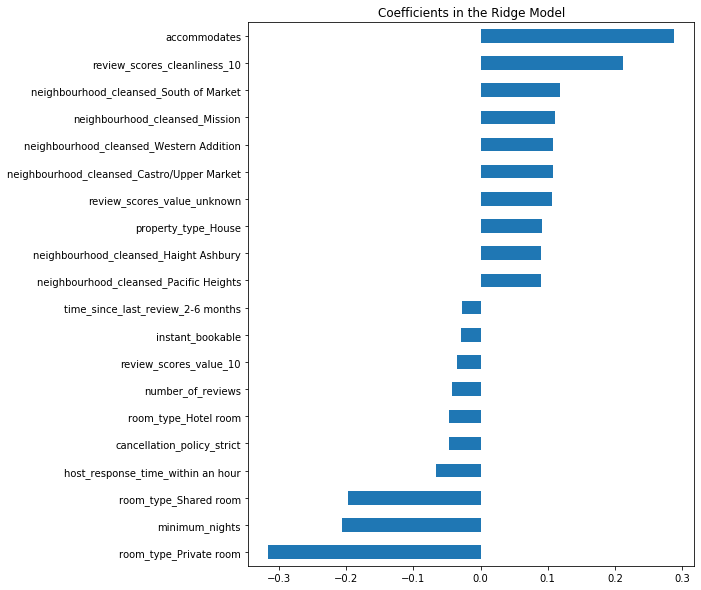

In [12]:
coef = pd.Series(ridge.coef_, index = col_list)   
print('****  Features with zero weight ****')
print(coef[coef==0])

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
plt.figure(figsize=(8.0, 10.0))
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model");
plt.savefig("Coefficients in the Ridge Model.png",bbox_inches = 'tight')

# Polynomial Models
## - Kernel Ridge Regression

#### GridSearchCV

{'alpha': 0.1, 'coef0': 0.005, 'kernel': 'laplacian'}
Training time = 8.7838 seconds

Training MAE = 0.1675
Validation MAE = 0.2566

Training MSE = 0.0568
Validation MSE = 0.1333

Training r2 = 0.8853
Validation r2 = 0.7321


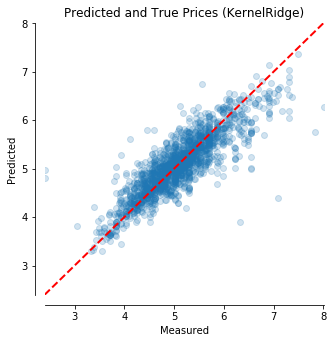

In [13]:
# grid search
alpha_ls = np.array([2, 1, 0.5, 0.1])
coef0_ls=np.array([0.005,0.05, 0.1 ,1, 2])
kernel_ls=np.array(['laplacian', 'polynomial'])

params={'alpha':alpha_ls,  
        'kernel':kernel_ls, 
        'coef0':coef0_ls}

krr_grid = GridSearchCV(KernelRidge(degree=2), param_grid=params, 
                        return_train_score=True, scoring='neg_mean_squared_error', cv=5).fit(X_train,y_train)

print(krr_grid.best_params_)  # {'alpha': 0.5, 'coef0': 0.1, 'kernel': 'laplacian'}
model_evaluation(krr_grid.best_estimator_, X_train, X_test, y_train, y_test, 'Predicted and True Prices (KernelRidge)')

Training time = 8.6477 seconds

Training MAE = 0.2242
Validation MAE = 0.266

Training MSE = 0.1008
Validation MSE = 0.142

Training r2 = 0.7964
Validation r2 = 0.7147


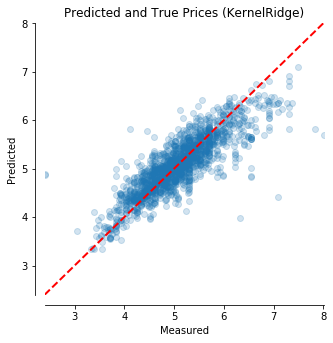

In [14]:
model_evaluation(KernelRidge(coef0=0.1, alpha=0.5,  kernel='laplacian'), X_train, X_test, y_train, y_test, 'Predicted and True Prices (KernelRidge)')

#### Validation Curves

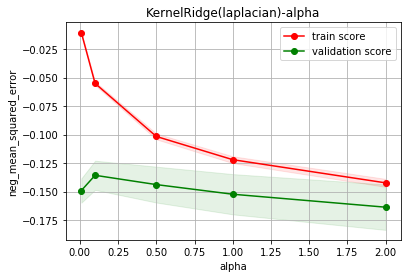

In [15]:
krr=KernelRidge(coef0=0.1, kernel='laplacian')
alpha_ls = np.array([2, 1,0.5, 0.1,0.01])
plot_validation_curve(krr,X_train,y_train,'alpha',alpha_ls,5,'alpha','KernelRidge(laplacian)-alpha')

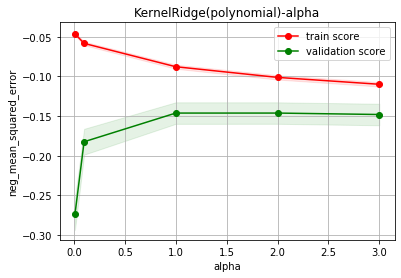

In [16]:
krr=KernelRidge(coef0=2, kernel='polynomial', degree=2 )
alpha_ls = np.array([3, 2,1, 0.1,0.01])
plot_validation_curve(krr,X_train,y_train,'alpha',alpha_ls,5,'alpha','KernelRidge(polynomial)-alpha')

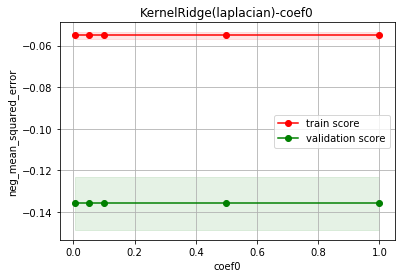

In [17]:
krr=KernelRidge( alpha=0.1 , kernel='laplacian')
coef0_ls=np.array([0.005, 0.05, 0.1, 0.5, 1])
plot_validation_curve(krr,X_train,y_train,'coef0',coef0_ls, 5,'coef0','KernelRidge(laplacian)-coef0')

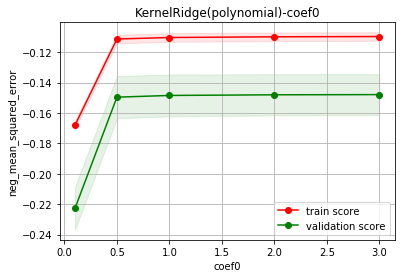

In [18]:
krr=KernelRidge( alpha=3 , kernel='polynomial', degree=2)
coef0_ls=np.array([0.1, 0.5, 1, 2, 3])
plot_validation_curve(krr,X_train,y_train,'coef0',coef0_ls,5,'coef0','KernelRidge(polynomial)-coef0')

#### Final Model

Training time = 10.4833 seconds

Training MAE = 0.1675
Validation MAE = 0.2566

Training MSE = 0.0568
Validation MSE = 0.1333

Training r2 = 0.8853
Validation r2 = 0.7321


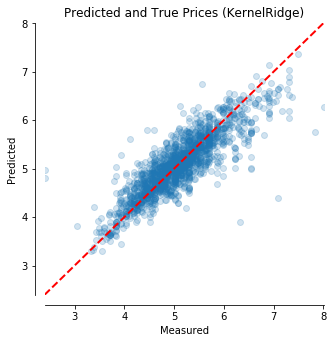

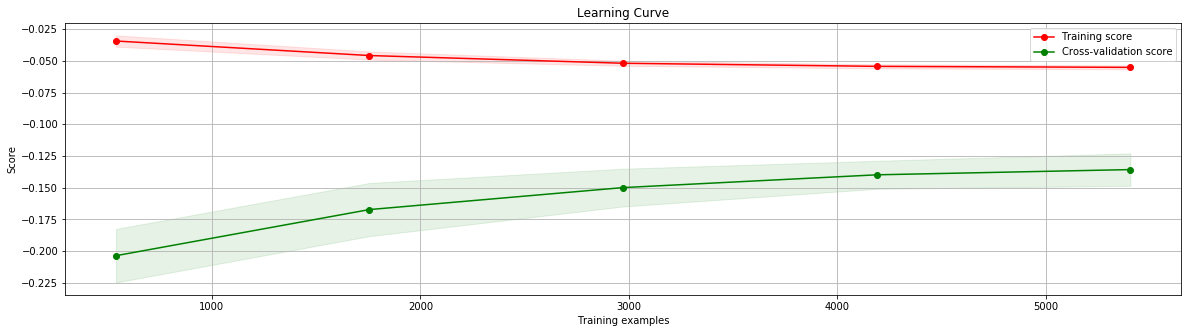

In [19]:
# krr=KernelRidge( kernel='polynomial', degree=2, coef0=3, alpha=3)
krr=KernelRidge( kernel='laplacian', coef0=1, alpha=0.1)
model_evaluation(krr, X_train, X_test, y_train, y_test, 'Predicted and True Prices (KernelRidge)')
learning_curve_plot(krr, X_train, y_train, 5, 'Learning Curve (KernelRidge)')

# Ensembled Models
## - Random Forest

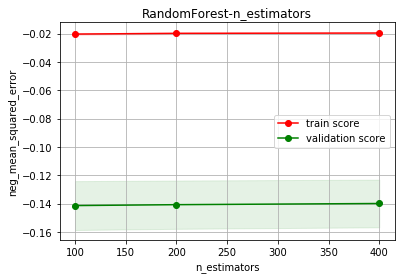

In [20]:
# rfr = RandomForestRegressor(min_samples_split =5,
#                                 max_leaf_nodes = None,
#                                 max_depth = None,
#                                 n_estimators = 600,
#                                 max_features = 'auto', random_state=34)

n_estimators_ls=[100, 200, 400]
rfr=RandomForestRegressor(random_state=34)
plot_validation_curve(rfr,X_train,y_train,'n_estimators',n_estimators_ls,5,'n_estimators','RandomForest-n_estimators')

Training time = 1.3439 seconds

Training MAE = 0.0983
Validation MAE = 0.2667

Training MSE = 0.023
Validation MSE = 0.1532

Training r2 = 0.9536
Validation r2 = 0.6921


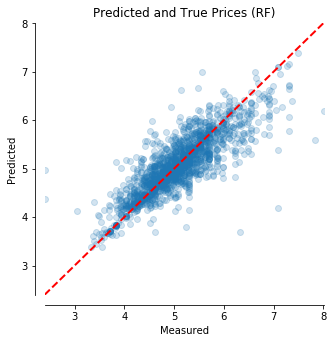

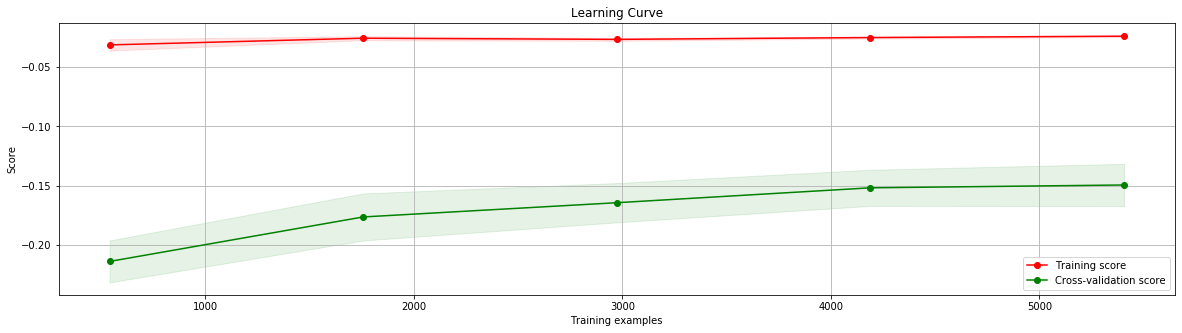

In [21]:
rfr=RandomForestRegressor(n_estimators=20, random_state=34)
model_evaluation(rfr, X_train, X_test, y_train, y_test, 'Predicted and True Prices (RF)')
learning_curve_plot(rfr, X_train, y_train, 5, 'Learning Curve (RF)')

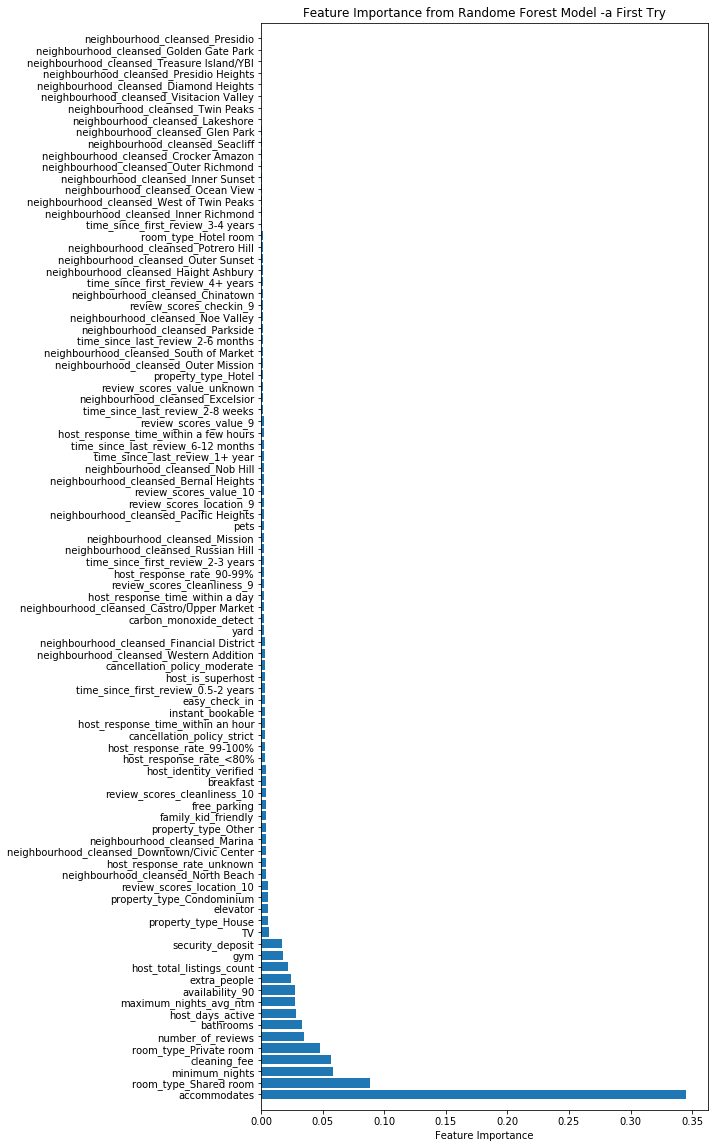

,weight,cum_sum
accommodates,0.345331,0.345331
room_type_Shared room,0.088134,0.433465
minimum_nights,0.058214,0.491679
cleaning_fee,0.056636,0.548315
room_type_Private room,0.048091,0.596406
number_of_reviews,0.034642,0.631048
bathrooms,0.033116,0.664164
host_days_active,0.028302,0.692466
maximum_nights_avg_ntm,0.027679,0.720145
availability_90,0.027588,0.747733


In [22]:
ft_importance(rfr.feature_importances_, col_list)    

## - Gradient Boosting Regression

With **huber loss** that makes it robust to outliers

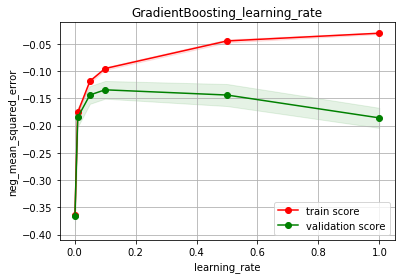

In [23]:
gbr=GradientBoostingRegressor(n_estimators=400, loss='huber', random_state=4)

learning_rate_ls=[0.001, 0.01, 0.05, 0.1, 0.5, 1]
plot_validation_curve(gbr,X_train,y_train,'learning_rate',learning_rate_ls,5,'learning_rate','GradientBoosting_learning_rate')


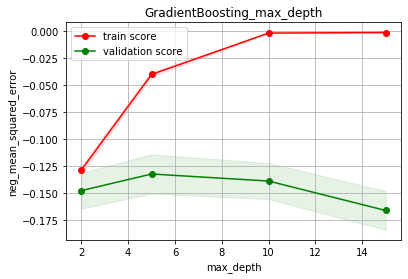

In [24]:
gbr=GradientBoostingRegressor(n_estimators=400, learning_rate=0.1, loss='huber', random_state=4)
max_depth_ls = [2, 5, 10,15]
plot_validation_curve(gbr,X_train,y_train,'max_depth',max_depth_ls,5,'max_depth','GradientBoosting_max_depth')

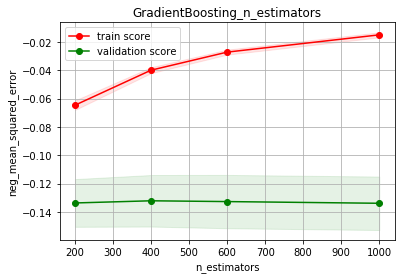

In [25]:
gbr=GradientBoostingRegressor(learning_rate=0.1, max_depth=5, loss='huber', random_state=4)
num_estimator_ls = [200, 400, 600, 1000]

plot_validation_curve(gbr,X_train,y_train,'n_estimators',num_estimator_ls,5,'n_estimators','GradientBoosting_n_estimators')

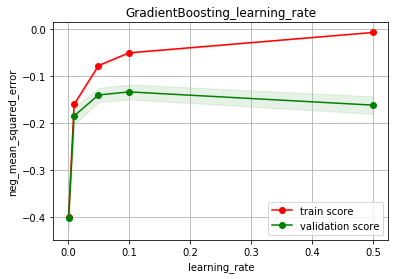

In [26]:
gbr=GradientBoostingRegressor(max_depth=5,n_estimators=200, loss='ls', random_state=4)

learning_rate_ls=[0.001, 0.01, 0.05, 0.1, 0.5]
plot_validation_curve(gbr,X_train,y_train,'learning_rate',learning_rate_ls,5,'learning_rate','GradientBoosting_learning_rate')

Training time = 5795.0328 seconds

Training MAE = 0.1532
Validation MAE = 0.246

Training MSE = 0.0565
Validation MSE = 0.1299

Training r2 = 0.8858
Validation r2 = 0.739
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='huber',
                          max_depth=5, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=600,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=4, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
Training time = 19.1049 seconds

Training MAE = 0.1532
Validation MAE = 0.246

Training MSE = 0.0565
Validation MSE = 0.1299

Training r2 = 0.8858
Validation r2 =

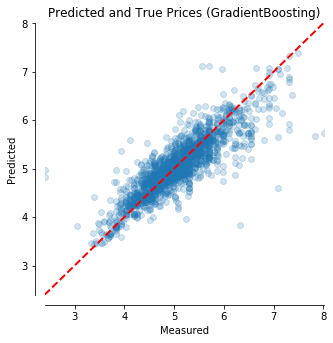

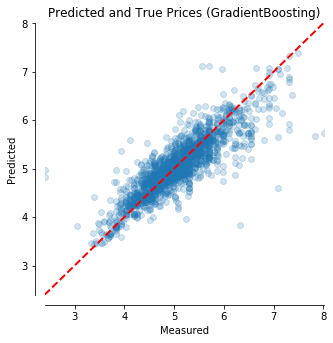

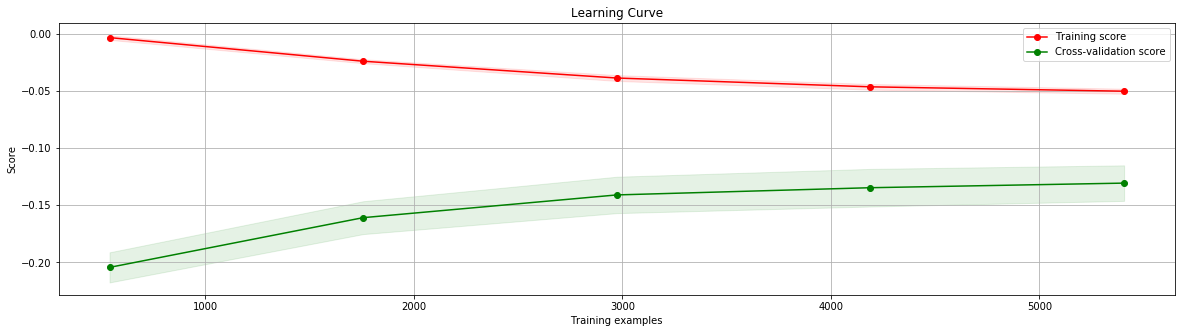

In [27]:
num_estimator_ls = [200, 400, 600]
learn_rate_ls = [0.01, 0.05, 0.1, 0.5]
max_depth_ls = [2, 5, 8, 12]

params = {"n_estimators" : num_estimator_ls,
          "max_depth" : max_depth_ls,
          "learning_rate" : learn_rate_ls
         }
    
gbr = GridSearchCV(GradientBoostingRegressor(random_state=4,loss='huber'),
                   params, return_train_score=True, scoring='neg_mean_squared_error', cv=5)

model_evaluation(gbr, X_train, X_test, y_train, y_test, 'Predicted and True Prices (GradientBoosting)')
print(gbr.best_estimator_)

model_evaluation(gbr.best_estimator_, X_train, X_test, y_train, y_test, 'Predicted and True Prices (GradientBoosting)')
learning_curve_plot(gbr.best_estimator_, X_train, y_train, 5, 'Learning Curve (GradientBoosting)')

Training time = 7.0354 seconds

Training MAE = 0.2093
Validation MAE = 0.2588

Training MSE = 0.0984
Validation MSE = 0.1417

Training r2 = 0.8012
Validation r2 = 0.7151


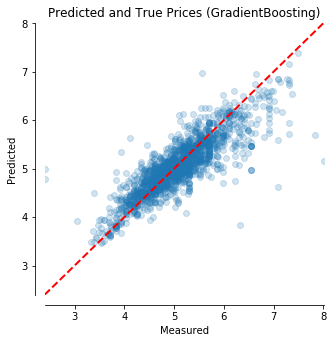

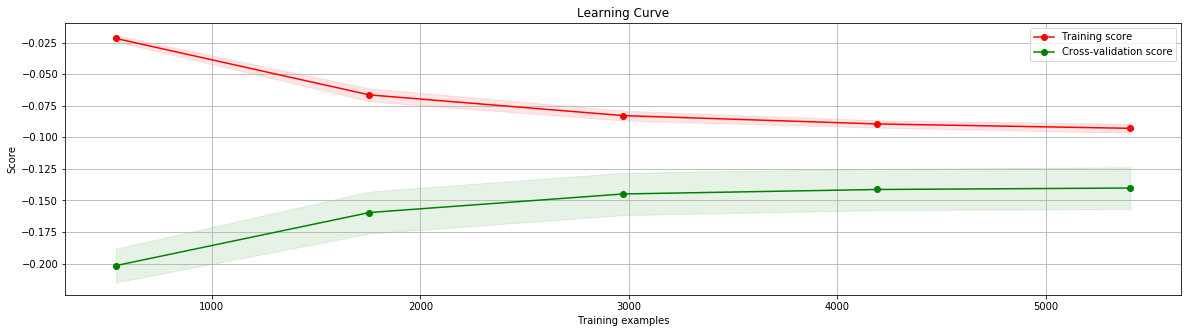

In [28]:
# Try another model
gbr_optimal=GradientBoostingRegressor(learning_rate=0.05,  max_depth=5, n_estimators=200, random_state=4,loss='huber')
model_evaluation(gbr_optimal, X_train, X_test, y_train, y_test, 'Predicted and True Prices (GradientBoosting)')
learning_curve_plot(gbr_optimal, X_train, y_train, 5, 'Learning Curve (GradientBoosting)')

## - ANN

Training time = 833.1427 seconds

Training MAE = 0.2436
Validation MAE = 0.2859

Training MSE = 0.117
Validation MSE = 0.1633

Training r2 = 0.7638
Validation r2 = 0.6717
MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=12, learning_rate='constant',
             learning_rate_init=0.0005, max_fun=15000, max_iter=4000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=300, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)
Training time = 5.2151 seconds

Training MAE = 0.2436
Validation MAE = 0.2859

Training MSE = 0.117
Validation MSE = 0.1633

Training r2 = 0.7638
Validation r2 = 0.6717


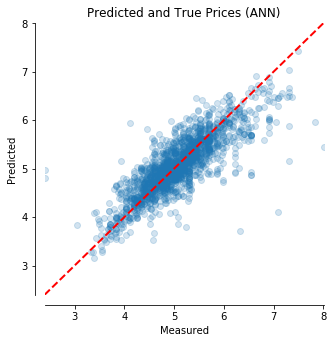

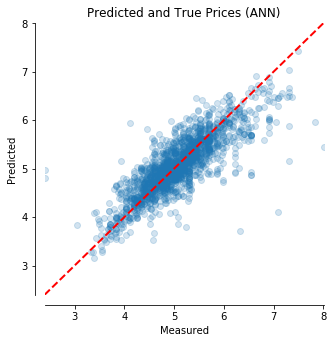

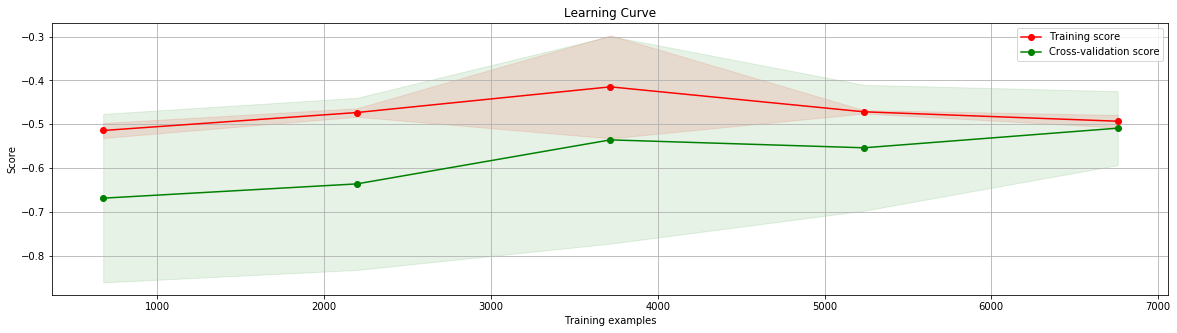

In [29]:
h_units = np.linspace(4, 16, 4).astype('int')
learning_rates = [0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1]
activationList = ['logistic', 'relu']

params={'hidden_layer_sizes':h_units, 'learning_rate_init':learning_rates, 'activation':activationList}


ann_grid = GridSearchCV(MLPRegressor(solver='adam', max_iter=4000,  random_state=300), params, 
                   return_train_score=True, scoring='neg_mean_squared_error', cv=5)

model_evaluation(ann_grid, X_train, X_test, y_train, y_test, 'Predicted and True Prices (ANN)')

print(ann_grid.best_estimator_)
model_evaluation(ann_grid.best_estimator_, X_train, X_test, y_train, y_test, 'Predicted and True Prices (ANN)')
learning_curve_plot(ann_grid.best_estimator_, X, y,5, 'Learning Curve (MLPR)')

# Two/Three Layer NN - Keras

In [30]:
# # build the model
# nn=models.Sequential()
# nn.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
# nn.add(layers.Dense(128, activation='relu'))
# # nn.add(layers.Dense(128, activation='relu'))
# nn.add(layers.Dense(1, activation='linear'))

# # compiling the model
# nn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

# # model Summary
# print(nn.summary())

# visuliza NN
# SVG(model_to_dot(nn, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

# iv1_dot = model_to_dot(nn, show_layer_names=False, show_shapes=True)
# iv1_dot.set_size('30x8')
# SVG(iv1_dot.create(prog=['dot'], format='svg'))


In [31]:
# # train the model
# nn_start=time.time()
# nn.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.1)
# nn_end=time.time()
# print(f"Time taken to run: {round((nn_end - nn_start)/60,1)} minutes")

# # model evaluation 
# nn_evaluation(nn,  X_train, X_test, y_train, y_test, skip_epochs=0)